In [1]:
import random
import numpy as np
import math
from numpy.random import seed
from numpy.random import rand
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

learning_rate = 0.00001
weight_decay  = 0.00001

d = 36
p = 0.1
private = False
num_epoch = 100

f = open('ydata-fp-td-clicks-v1_0.20090501')

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, emb_dim=10):
        super().__init__()
        self.emb_dim = emb_dim
        self.encoder = nn.Linear(36, self.emb_dim)
        self.decoder = nn.Linear(self.emb_dim, 36)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size,36)
        return out
    
    def encoding_result(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        return encoded
    
def parse_context(raw_context):
#         print(raw_context)
    if raw_context[0] == 'user':
        arm = 'user'
    else:
        arm = int(raw_context[0])

    context = np.zeros(6)
    for i in range(1, len(raw_context)):
        idx_ctx = raw_context[i].split(':')
        context[int(idx_ctx[0])-1] = float(idx_ctx[1])

    return arm, context

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder(emb_dim=10).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

cuda:0


In [4]:
num_epoch = 200000
loss_arr = []

for k in tqdm.tqdm(range(num_epoch)):
    
    line = f.readline()
    raw_data = line.strip().split(' |')

    info = raw_data[0].split(' ')
    time = int(info[0])
    chosen_arm = int(info[1])
    is_clicked = bool(int(info[2]))
    user_context = parse_context(raw_data[1].split(' '))[1]


    arms = []
    arm_contexts = []
    for i in range(2, len(raw_data)):
        arm, context = parse_context(raw_data[i].split(' '))
        arms.append(arm)
        arm_contexts.append(context)

    x = np.outer(user_context, arm_contexts[0]).flatten()

    for j in range(1, len(arm_contexts)):
        x = np.vstack((x, np.outer(user_context, arm_contexts[j]).flatten()))

    
    x = torch.from_numpy(x).type(torch.FloatTensor).to(device)
    
    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output,x)
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        loss_arr.append(loss.cpu().data.numpy())

100%|██████████| 200000/200000 [07:06<00:00, 469.29it/s]


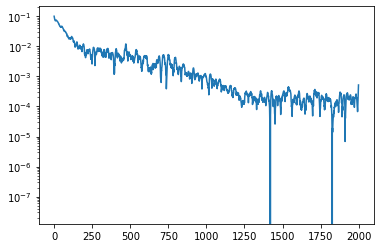

In [9]:
from scipy.signal import savgol_filter

plt.plot(savgol_filter(loss_arr,21, 3))
plt.yscale("log")

In [10]:
model.eval()
with torch.no_grad():
    model.eval()
    print(x[0])
    print(model.encoding_result(x)[0])
    print(model.forward(x)[0])

tensor([1.0000e+00, 3.0601e-01, 4.5000e-04, 7.7048e-02, 2.3044e-01, 3.8605e-01,
        3.1284e-01, 9.5732e-02, 1.4078e-04, 2.4104e-02, 7.2091e-02, 1.2077e-01,
        2.1722e-01, 6.6472e-02, 9.7750e-05, 1.6737e-02, 5.0056e-02, 8.3860e-02,
        2.3401e-02, 7.1609e-03, 1.0530e-05, 1.8030e-03, 5.3925e-03, 9.0341e-03,
        4.4462e-01, 1.3606e-01, 2.0008e-04, 3.4257e-02, 1.0246e-01, 1.7165e-01,
        1.9210e-03, 5.8784e-04, 8.6445e-07, 1.4801e-04, 4.4267e-04, 7.4161e-04],
       device='cuda:0')
tensor([ 0.1048, -0.0400, -0.2630,  0.3271,  0.3861, -0.4079,  0.4408,  0.2785,
         0.4335, -0.3402], device='cuda:0')
tensor([ 9.9979e-01,  3.1087e-01,  2.9247e-04,  7.7295e-02,  2.3015e-01,
         3.8118e-01,  3.1159e-01,  9.9070e-02,  8.4176e-05,  2.5126e-02,
         7.8419e-02,  1.1128e-01,  2.1742e-01,  6.8617e-02,  6.2084e-05,
         1.7236e-02,  5.1332e-02,  8.0503e-02,  2.5318e-02,  1.0208e-02,
         1.9596e-05, -8.1502e-04, -1.8751e-02,  2.9139e-02,  4.4383e-01,
      

In [11]:
torch.save(model.state_dict(), './r6a_autoencoder.pt')